#  Handling Imbalanced Datasets in Fraud Detection

This notebook demonstrates how to solve **class imbalance problems** in machine learning using techniques like:

- Random Oversampling
- Random Undersampling
- SMOTE (Synthetic Minority Oversampling)
- SMOTE + Tomek Links (Combination)

**Dataset:** Credit Card Fraud Detection ([Source on Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud))

In [34]:
#  Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings('ignore')

## 1️⃣ Load the Dataset
We’ll use a public GitHub mirror of the Kaggle dataset.

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


## 2️⃣ Explore the Dataset

Shape: (41683, 31)
Class
0.0    41574
1.0      108
Name: count, dtype: int64


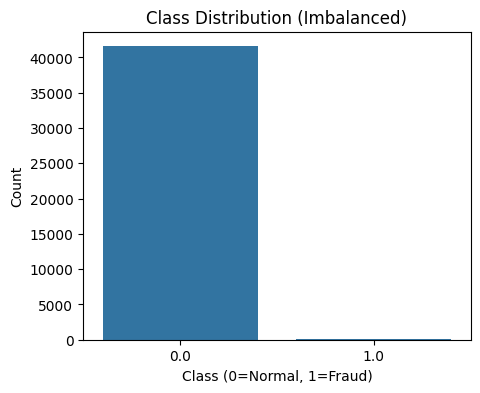

In [4]:
print('Shape:', df.shape)
print(df['Class'].value_counts())

plt.figure(figsize=(5,4))
sns.barplot(x=df['Class'].value_counts().index, y=df['Class'].value_counts().values)
plt.title('Class Distribution (Imbalanced)')
plt.xlabel('Class (0=Normal, 1=Fraud)')
plt.ylabel('Count')
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41683 entries, 0 to 41682
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    41683 non-null  int64  
 1   V1      41683 non-null  float64
 2   V2      41683 non-null  float64
 3   V3      41682 non-null  float64
 4   V4      41682 non-null  float64
 5   V5      41682 non-null  float64
 6   V6      41682 non-null  float64
 7   V7      41682 non-null  float64
 8   V8      41682 non-null  float64
 9   V9      41682 non-null  float64
 10  V10     41682 non-null  float64
 11  V11     41682 non-null  float64
 12  V12     41682 non-null  float64
 13  V13     41682 non-null  float64
 14  V14     41682 non-null  float64
 15  V15     41682 non-null  float64
 16  V16     41682 non-null  float64
 17  V17     41682 non-null  float64
 18  V18     41682 non-null  float64
 19  V19     41682 non-null  float64
 20  V20     41682 non-null  float64
 21  V21     41682 non-null  float64
 22

In [11]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
41678,40781,-0.447381,1.134089,0.534095,-0.192366,1.344408,-0.370402,1.088646,-0.094025,-0.444502,...,-0.050234,-0.092340,-0.463501,-0.908485,0.202750,-0.506844,-0.058317,-0.085094,1.00,0.0
41679,40782,1.133168,0.406826,0.956032,2.315761,-0.242409,0.225013,-0.295703,0.130832,-0.768433,...,0.180411,0.487918,-0.121882,0.029950,0.465114,0.097369,0.010912,0.018509,10.65,0.0
41680,40783,-0.536190,1.355132,0.064049,0.884589,0.581654,-0.179437,0.466058,0.213312,-0.130088,...,-0.013520,0.198903,-0.112066,-0.505780,-0.266556,-0.349786,-0.367509,-0.399716,1.00,0.0
41681,40783,-0.498757,0.332449,1.917148,-2.340131,-1.098398,-0.863136,-0.055820,-0.084046,1.673677,...,0.371752,1.441352,-0.250882,0.483504,-0.140917,-0.613552,0.380606,0.226502,26.59,0.0
41682,40784,-0.621229,-0.733600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# drop the last row
df.drop(df.tail(1).index, inplace=True)

In [13]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
41677,40781,1.059978,0.041244,0.382701,1.250712,-0.311883,-0.366149,0.050150,-0.023937,0.100562,...,0.093891,0.172183,-0.095805,0.051263,0.493764,-0.303730,0.022556,0.030893,69.12,0.0
41678,40781,-0.447381,1.134089,0.534095,-0.192366,1.344408,-0.370402,1.088646,-0.094025,-0.444502,...,-0.050234,-0.092340,-0.463501,-0.908485,0.202750,-0.506844,-0.058317,-0.085094,1.00,0.0
41679,40782,1.133168,0.406826,0.956032,2.315761,-0.242409,0.225013,-0.295703,0.130832,-0.768433,...,0.180411,0.487918,-0.121882,0.029950,0.465114,0.097369,0.010912,0.018509,10.65,0.0
41680,40783,-0.536190,1.355132,0.064049,0.884589,0.581654,-0.179437,0.466058,0.213312,-0.130088,...,-0.013520,0.198903,-0.112066,-0.505780,-0.266556,-0.349786,-0.367509,-0.399716,1.00,0.0
41681,40783,-0.498757,0.332449,1.917148,-2.340131,-1.098398,-0.863136,-0.055820,-0.084046,1.673677,...,0.371752,1.441352,-0.250882,0.483504,-0.140917,-0.613552,0.380606,0.226502,26.59,0.0


## 3️⃣ Split Data into Train and Test Sets

In [14]:
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4️⃣ Define Helper Function for Evaluation

In [16]:
def evaluate_model(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    print(f'\n===== {title} =====')
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))
    print('ROC-AUC:', roc_auc_score(y_test, y_pred))

## 5️⃣ Baseline Model (No Resampling)

In [24]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
evaluate_model(lr, X_test_scaled, y_test, 'Baseline (No Resampling)')


===== Baseline (No Resampling) =====
[[12460    13]
 [   10    22]]
              precision    recall  f1-score   support

         0.0     0.9992    0.9990    0.9991     12473
         1.0     0.6286    0.6875    0.6567        32

    accuracy                         0.9982     12505
   macro avg     0.8139    0.8432    0.8279     12505
weighted avg     0.9982    0.9982    0.9982     12505

ROC-AUC: 0.8432288743686362


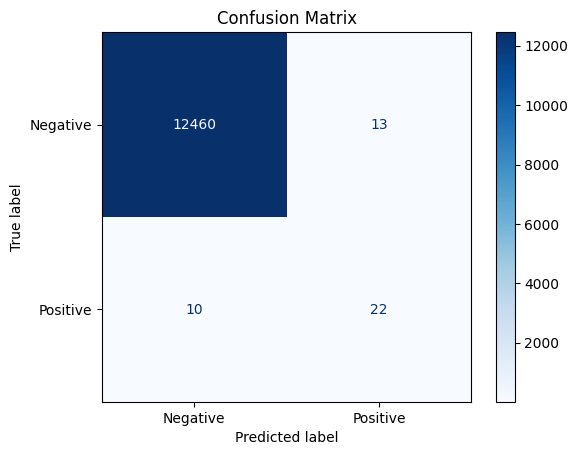

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
y_pred = lr.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix")
plt.show()


## 6️⃣ Random Oversampling

In [27]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train_scaled, y_train)
lr.fit(X_ros, y_ros)
evaluate_model(lr, X_test_scaled, y_test, 'Random Oversampling')


===== Random Oversampling =====
[[12262   211]
 [    4    28]]
              precision    recall  f1-score   support

         0.0     0.9997    0.9831    0.9913     12473
         1.0     0.1172    0.8750    0.2066        32

    accuracy                         0.9828     12505
   macro avg     0.5584    0.9290    0.5990     12505
weighted avg     0.9974    0.9828    0.9893     12505

ROC-AUC: 0.9290417301370961


## 7️⃣ Random Undersampling

In [30]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train_scaled, y_train)
lr.fit(X_rus, y_rus)
evaluate_model(lr, X_test_scaled, y_test, 'Random Undersampling')


===== Random Undersampling =====
[[11889   584]
 [    2    30]]
              precision    recall  f1-score   support

         0.0     0.9998    0.9532    0.9759     12473
         1.0     0.0489    0.9375    0.0929        32

    accuracy                         0.9531     12505
   macro avg     0.5243    0.9453    0.5344     12505
weighted avg     0.9974    0.9531    0.9737     12505

ROC-AUC: 0.9453394331756595


## 8️⃣ SMOTE (Synthetic Minority Oversampling)

In [31]:
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train_scaled, y_train)
lr.fit(X_sm, y_sm)
evaluate_model(lr, X_test_scaled, y_test, 'SMOTE Oversampling')


===== SMOTE Oversampling =====
[[12283   190]
 [    4    28]]
              precision    recall  f1-score   support

         0.0     0.9997    0.9848    0.9922     12473
         1.0     0.1284    0.8750    0.2240        32

    accuracy                         0.9845     12505
   macro avg     0.5641    0.9299    0.6081     12505
weighted avg     0.9974    0.9845    0.9902     12505

ROC-AUC: 0.9298835484646838


In [32]:
# adasyn (adaptive Synthetic Oversampling)
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train_scaled, y_train)
lr.fit(X_adasyn, y_adasyn)
evaluate_model(lr, X_test_scaled, y_test, 'ADASYN')
#


===== ADASYN =====
[[12119   354]
 [    4    28]]
              precision    recall  f1-score   support

         0.0     0.9997    0.9716    0.9854     12473
         1.0     0.0733    0.8750    0.1353        32

    accuracy                         0.9714     12505
   macro avg     0.5365    0.9233    0.5604     12505
weighted avg     0.9973    0.9714    0.9833     12505

ROC-AUC: 0.9233093481920949


## 9️⃣ SMOTE + Tomek Links (Combination)

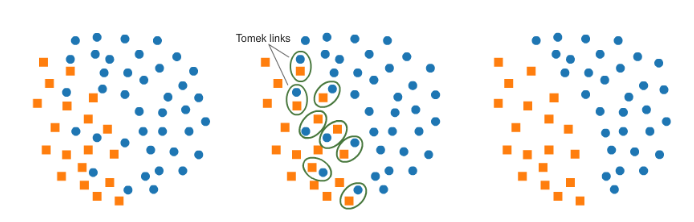

In [33]:
smt = SMOTETomek(random_state=42)
X_smt, y_smt = smt.fit_resample(X_train_scaled, y_train)
lr.fit(X_smt, y_smt)
evaluate_model(lr, X_test_scaled, y_test, 'SMOTE + Tomek Links')


===== SMOTE + Tomek Links =====
[[12283   190]
 [    4    28]]
              precision    recall  f1-score   support

         0.0     0.9997    0.9848    0.9922     12473
         1.0     0.1284    0.8750    0.2240        32

    accuracy                         0.9845     12505
   macro avg     0.5641    0.9299    0.6081     12505
weighted avg     0.9974    0.9845    0.9902     12505

ROC-AUC: 0.9298835484646838
